## Deep face recognition with Keras

### First, lets install the required libraries. Upload the `requirements.txt` file given and run the below commands.

In [15]:
# !pip3 install -r requirements.txt --user

In [16]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pip3 install request

### Installing Dlib

In [18]:
!apt install python python-pip build-essential cmake pkg-config libx11-dev libatlas-base-dev libgtk-3-dev libboost-python-dev -y

!pip3 install dlib


Reading package lists... 0%

Reading package lists... 0%

Reading package lists... 0%

Reading package lists... 7%

Reading package lists... 7%

Reading package lists... 7%

Reading package lists... 7%

Reading package lists... 68%

Reading package lists... 69%

Reading package lists... 69%

Reading package lists... 70%

Reading package lists... 70%

Reading package lists... 75%

Reading package lists... 75%

Reading package lists... 75%

Reading package lists... 75%

Reading package lists... 84%

Reading package lists... 84%

Reading package lists... 84%

Reading package lists... 84%

Reading package lists... 84%

Reading package lists... 84%

Reading package lists... 84%

Reading package lists... 84%

Reading package lists... 88%

Reading package lists... 88%

Reading package lists... 88%

Reading package lists... 88%

Reading package lists... 93%

Reading package lists... 93%

Reading package lists... 93%

Reading package lists... 93%

Reading package lists... 94%

Reading package 

### Download Dlib's face landmarks data file for running face alignment.

This will helps us in aligning faces before we learn the features for each face. **`Run the below code.`** It will create a directory with name **`models` **and save **`landmarks.dat`** file in that folder.

In [ ]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)


### Training the network

The CNN model is taken from the Keras-OpenFace project. The architecture details aren't too important here, it's only useful to know that there is a fully connected layer with 128 hidden units followed by an L2 normalization layer on top of the convolutional base. These two top layers are referred to as the embedding layer from which the 128-dimensional embedding vectors can be obtained. The complete model is defined in `model.py` and a graphical overview is given in `model.png`. A Keras version of the `nn4.small2` model can be created with `create_model()`.


**Run the below code to initialize the model**

In [ ]:
from model import create_model

nn4_small2 = create_model()

#### Idea of Training the model with Triplet loss function 

Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a triplet loss L that is minimized when the distance between an anchor image xai and a positive image xpi (same identity) in embedding space is smaller than the distance between that anchor image and a negative image xni (different identity) by at least a margin α.

In [ ]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [22]:
from data import triplet_generator

# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

# Please note that the current implementation of the generator only generates 
# random image data. The main goal of this code snippet is to demonstrate 
# the general setup for model training. In the following, we will anyway 
# use a pre-trained model so we don't need a generator here that operates 
# on real training data.

Epoch 1/10
100/100 [==============================] - 43s 431ms/step - loss: 0.8043
Epoch 2/10
100/100 [==============================] - 20s 197ms/step - loss: 0.8081
Epoch 3/10
100/100 [==============================] - 20s 196ms/step - loss: 0.8001
Epoch 4/10
100/100 [==============================] - 20s 196ms/step - loss: 0.8000
Epoch 5/10
100/100 [==============================] - 20s 200ms/step - loss: 0.8000
Epoch 6/10
100/100 [==============================] - 20s 199ms/step - loss: 0.8001
Epoch 7/10
100/100 [==============================] - 20s 198ms/step - loss: 0.8000
Epoch 8/10
100/100 [==============================] - 20s 197ms/step - loss: 0.7994
Epoch 9/10
100/100 [==============================] - 20s 199ms/step - loss: 0.8009
Epoch 10/10
100/100 [==============================] - 20s 199ms/step - loss: 0.8000


For this project, we are considering a pre-trained model given in file path **`nn4.small2.v1.h5`**.

Using **load_weights()** function load the given pre-trained weight file.

In [ ]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('nn4.small2.v1.h5')

### Dataset

To demonstrate face recognition on a custom dataset, a small dataset is used. It consists of around 15-25 face images of 10 different persons. The metadata for each image (file and identity name) are loaded into memory for later processing.


Upload Images zip file given to drive and download and extract it using the below code. And we will pass the folder `images` to `load_metadata` function to save all the images filenames and person numbers.

#### Import drive module from google.colab

In [ ]:
from google.colab import drive

#### Give a path to mount the files in your drive

In [50]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Using the above given mounted path, give the images.zip path dependent on where you placed the file in your drive.

In [ ]:
## For example
images_path = "/content/drive/My Drive/Project-2/images.zip"

#### Using ZipFile module to extract the images zip file

In [ ]:


from zipfile import ZipFile

In [ ]:



with ZipFile(images_path, 'r') as zip:
  zip.extractall()

#### Run the below function to load the images from the extracted images folder from the above step and map each image with person id 


In [ ]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

### Face alignment
The nn4.small2.v1 model was trained with aligned face images, therefore, the face images from the custom dataset must be aligned too. Here, we use Dlib for face detection and OpenCV for image transformation and cropping to produce aligned 96x96 RGB face images. We are using the AlignDlib utility from the OpenFace project.

##### 1. Run the below code to import AlignDlib

For this you need align.py available in the environment.

In [ ]:
from align import AlignDlib

Use the landmarks data file downloaded in the first steps for face alignment. file path **`models/landmarks.dat`**

In [ ]:
# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

##### 2. Run the beloiw code to  load an image from the metadata created in the step before Face Alignment

You can access each image path from `metadata[i].image_path()` where, i is the image number. i can take values from 1 to no.of images in the dataset given.

In [ ]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [ ]:
# Load an image
# for example, loading the image with index 1
one_image = load_image(metadata[0].image_path())

#### Write code to load 2nd and 3rd images in the metadata using load_image()

In [ ]:
second_image = load_image(metadata[1].image_path())
third_image = load_image(metadata[2].image_path())

##### 3. Run the below code to align the above loaded image.

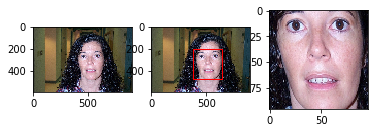

In [63]:
# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(one_image)

# Transform image using specified face landmark indices and crop image to 96x96
one_image_aligned = alignment.align(96, one_image, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Show original image
plt.subplot(131)
plt.imshow(one_image)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(one_image)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(one_image_aligned);

#### Write a function image_align() which take image path as input and returns the aligned image in output.



In [ ]:
def image_align(img_path):
    img = load_image(img_path)
    bb = alignment.getLargestFaceBoundingBox(img)
    return alignment.align(96, img, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Generate embeddings for each image in the dataset

Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

#### Get embedding vector for first image in the metadata using the pre-trained model

In [ ]:
# Align the image
img_aligned = image_align(metadata[0].image_path())

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img_aligned / 255.).astype(np.float32)

# obtain embedding vector for an image
embedding_vector = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

#### Write code to iterate through metadata and create embeddings for each image using nn4_small2_pretrained.predict() and store in a list with name `embeddings`

If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 128-zeroes as the final embedding from the model is of length 128.

In [66]:
embeddings = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    try:
        img = image_align(m.image_path())
        # scale RGB values to interval [0,1]
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    except:
        print(i,m)

78 images/subject_8/image_0320.jpg
88 images/subject_8/image_0327.jpg


#### Write code to get the distance between given 2 pairs of images.

Consider distance metric as "Squared L2 distance"

squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2



##### Plot images and get distance between the pairs given below.

1. 2,3 and 2,120

2. 30,31 and 30,100

3. 70,72 and 70,115

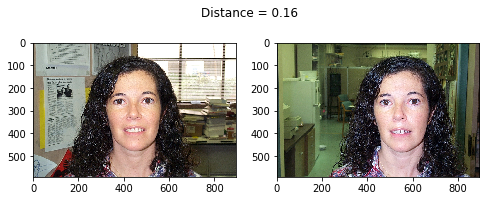

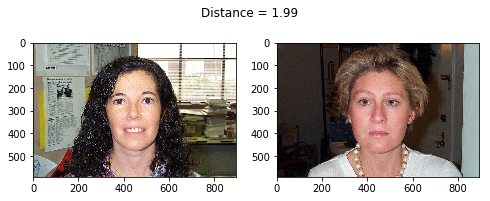

In [67]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 120)

#### Now lets build a SVM classifier to predict person in the given image. 

Use LinearSVC in sklearn.svm

Run the below code to divide half of the images as training set and another half of the images as test set.

In [69]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

## checking the shapes of metaadata and test and train sets
print(metadata.shape)
print(train_idx.shape)
print(test_idx.shape)


# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]



(201,)
(201,)
(201,)


#### Build SVM and report the accuracy

In [70]:
svc = LinearSVC()

svc.fit(X_train, y_train)

acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'SVM accuracy = {acc_svc}')

SVM accuracy = 0.9603960396039604


#### Test the classifier

Take 35th image from test set and plot the image, report to which person(folder name in dataset) the image belongs to.

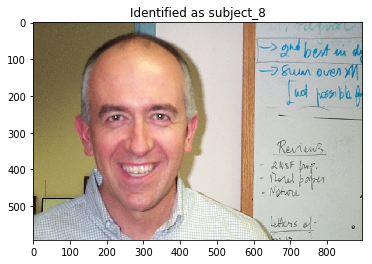

In [71]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 35

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embeddings[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');